In [1]:
import seaborn as sns
sns.set()

In [2]:
from static_grader import grader

# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this miniproject, you build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.  Each of your models will be scored by comparing its accuracy to the accuracy of a reference model that we developed.  A score of 1 indicates that your model performs as well as the reference model; not that your accuracy is 100%!

You will be given both a training set and a test set.  Ground truth values are provided for the training set.  You should train your models on this set, and then make predictions for each of the test images.  These predictions will be submitted to the grader.

## A note on scoring

It **is** possible to score above 1 on these questions. This indicates that you've beaten our reference model&mdash;we compare our model's score on a test set to your score on a test set. See how high you can go!

## Downloading the data

We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes.  The following cell will download the data, in NumPy's `.npy` format.

In [3]:
!aws s3 sync s3://dataincubator-course/cifar10/ . --exclude 'valid*'

We can load in the data like so:

In [3]:
import numpy as np
import gzip

train_images = np.load(gzip.open('train_images.npy.gz', 'rb'))
train_labels = np.load(gzip.open('train_labels.npy.gz', 'rb'))
test_images = np.load(gzip.open('test_images.npy.gz', 'rb'))

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

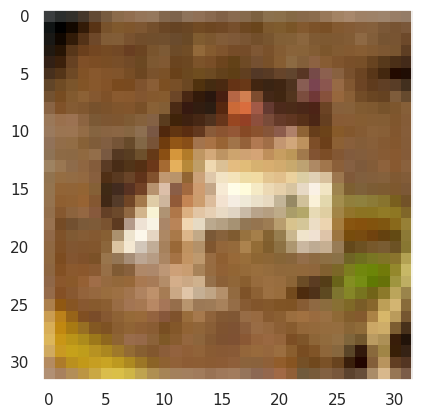

In [10]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[0])

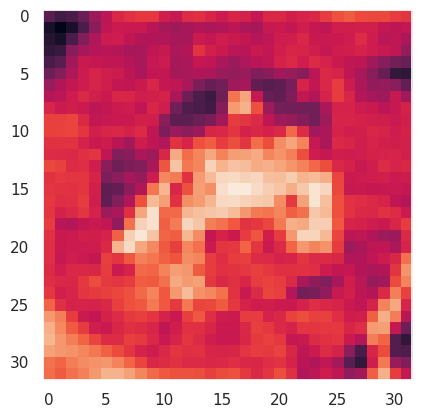

In [6]:
# test - display red channel of an image
matplotlib.pyplot.imshow(train_images[0][:, :, 0])

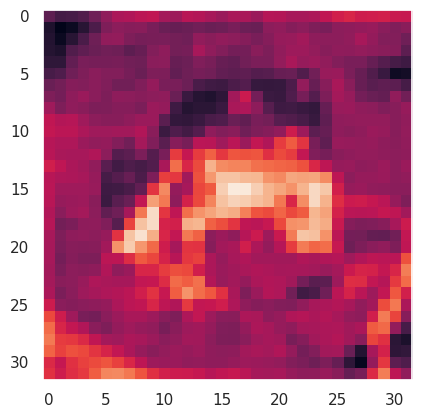

In [7]:
# test - display green channel of an image
matplotlib.pyplot.imshow(train_images[0][:, :, 1])

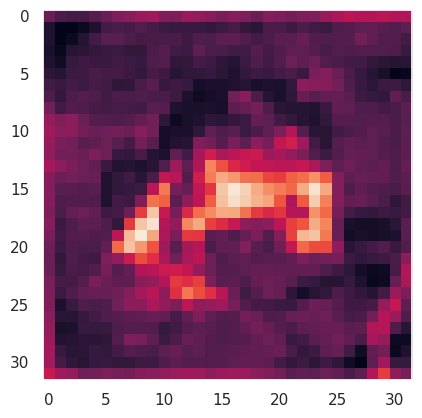

In [8]:
# test - display blue channel of an image
matplotlib.pyplot.imshow(train_images[0][:, :, 2])

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

In [9]:
train_labels[0]

6

In [10]:
# test

print(len(train_labels))
train_labels

50000


array([6, 9, 9, ..., 9, 1, 1])

In [11]:
# test

print(len(train_images))
train_images[0][0]

50000


array([[0.23137255, 0.24313726, 0.24705882],
       [0.16862746, 0.18039216, 0.1764706 ],
       [0.19607843, 0.1882353 , 0.16862746],
       [0.26666668, 0.21176471, 0.16470589],
       [0.38431373, 0.28627452, 0.20392157],
       [0.46666667, 0.35686275, 0.24705882],
       [0.54509807, 0.41960785, 0.29411766],
       [0.5686275 , 0.43137255, 0.3137255 ],
       [0.58431375, 0.45882353, 0.34901962],
       [0.58431375, 0.47058824, 0.3647059 ],
       [0.5137255 , 0.40392157, 0.3019608 ],
       [0.49019608, 0.3882353 , 0.29803923],
       [0.5568628 , 0.4509804 , 0.35686275],
       [0.5647059 , 0.4392157 , 0.3372549 ],
       [0.5372549 , 0.4117647 , 0.30980393],
       [0.5058824 , 0.38039216, 0.2784314 ],
       [0.5372549 , 0.41568628, 0.30980393],
       [0.5254902 , 0.41568628, 0.29803923],
       [0.4862745 , 0.38039216, 0.2509804 ],
       [0.54509807, 0.44313726, 0.30588236],
       [0.54509807, 0.4392157 , 0.29411766],
       [0.52156866, 0.4117647 , 0.27058825],
       [0.

In [12]:
# check the shapes of the training and test sets

print(f"The shape of the train images: {np.shape(train_images)}")
print(f"The shape of the test images: {np.shape(test_images)}")
print(f"The shape of the first test image: {np.shape(test_images[0])}")

The shape of the train images: (50000, 32, 32, 3)
The shape of the test images: (10000, 32, 32, 3)
The shape of the first test image: (32, 32, 3)


The human-readable names associated with this classes are

In [13]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
label_names[train_labels[0]]

'frog'

So we can see that the image above is a frog.  (Now you see it!)

# Questions

## Perceptual Delta

Since we already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, we need to develop a metric to determine the distance between two images.  We'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While we could just take RMS difference of the red, green, and blue pixels, let's be slightly more sophisticated and look at human vision for a metric.  After all, we're pretty good at image classifications, so there might be some useful optimization here.

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  We're going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.

Build a graph that takes in a series of images, as well as a base image, and returns a result containing the $\Delta C$ value (for each pixel) between the base image and each image in the series.  

(Note that the intention here in our solution is that `images` will be a stack of images, while `base` is a single image.  Since the function is decorated with `tf.function` the computations within the function will be recorded in a computation graph and the output from this function will be a tensor.)

In [4]:
import tensorflow as tf

@tf.function
def delta_func(images, base):
    
    red_images = images[:,:,:,0]
    green_images = images[:,:,:,1]
    blue_images = images[:,:,:,2]
    
    red_base = base[:,:,0]
    green_base = base[:,:,1]
    blue_base = base[:,:,2]
    
    delta_red = red_images - red_base
    delta_green = green_images - green_base
    delta_blue = blue_images - blue_base
    
    r_bar = 0.5 * (red_images + red_base)
    
    delta_c = (2*delta_red**2 + 4*delta_green**2 + 3*delta_blue**2 + r_bar*(delta_red**2 - delta_blue**2))**0.5
    
    return delta_c

In [16]:
# store the distances in 'deltas' variable

deltas = delta_func(train_images, test_images[0])

In [17]:
# double check the shape of deltas tensor

print(deltas.shape)

deltas

(50000, 32, 32)


<tf.Tensor: shape=(50000, 32, 32), dtype=float32, numpy=
array([[[0.5333113 , 0.33148462, 0.38341942, ..., 1.4372569 ,
         1.3731312 , 1.3552717 ],
        [0.05840993, 0.18890691, 0.16645688, ..., 0.955948  ,
         0.9151288 , 0.95025355],
        [0.1038    , 0.16666979, 0.25960702, ..., 0.9050011 ,
         0.9138099 , 0.7969412 ],
        ...,
        [1.0078584 , 1.2406718 , 1.13792   , ..., 1.2719773 ,
         0.31694952, 0.2963636 ],
        [1.2599063 , 1.3781216 , 1.1557546 , ..., 1.6132216 ,
         0.65660256, 0.53857315],
        [1.1906118 , 1.1824328 , 0.94303674, ..., 2.0099993 ,
         1.2699544 , 0.9897758 ]],

       [[1.8597541 , 1.3769249 , 1.022578  , ..., 0.8981979 ,
         0.8683449 , 0.789697  ],
        [1.668902  , 1.6043265 , 1.2610751 , ..., 0.96791995,
         0.76596785, 0.6929272 ],
        [1.612187  , 1.5200388 , 1.1561263 , ..., 0.7777319 ,
         0.6492888 , 0.640426  ],
        ...,
        [0.861128  , 0.86308736, 0.6458334 , ..., 0

As stated, for two images, $I_1$ and $I_2$, we define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).

Using `delta_func` compute the distance between the first test image and all of the training images.

**Checkpoint:** The mean value of the distances is 1.159, and the standard deviation of the distances is 0.182.

In [18]:
# compute the means of 'deltas' tensor across 2nd and 3rd columns ()

means = tf.reduce_mean(deltas, axis=[1,2])
means

<tf.Tensor: shape=(50000,), dtype=float32, numpy=
array([0.9794363, 1.0103867, 1.5204016, ..., 1.4538497, 1.235421 ,
       1.2954228], dtype=float32)>

In [19]:
# convert the tensor to numpy array

means_array = means.numpy()

In [20]:
# checkpoint: The mean value of the distances is 1.159, and the standard deviation of the distances is 0.182.

print(f"The mean of the distances: {means_array.mean()}")
print(f"The standard deviation of the distances: {means_array.std()}")

The mean of the distances: 1.1587646007537842
The standard deviation of the distances: 0.18163733184337616


From these, find the 100 closest images from the training set to this first test image.  (Note that `numpy.argsort` might help here.)  Submit a list of the indices of these images to the grader.

In [21]:
# sort the distances to get the indices, choose only first 100 smallest ones

indices = means_array.argsort()[:100]
indices

array([27912, 23437, 47732, 25053, 29251,  3616, 43445,  5555, 46911,
       16269, 45450, 47893, 27833, 41078,  6385, 32788,  2108, 44366,
       40857, 18619, 32596, 43840, 42187,  7982, 47629, 14298, 29521,
       15860, 48219, 25953, 24522,  1363, 32891, 18702, 19759, 16247,
        5859,  3303, 37982,  5463,  9738,  8448,  4881, 14185, 18347,
       35163, 13960, 39700,  7837, 36899, 31793, 11317, 29615, 10413,
       45178, 16021, 40089,  6224, 42620, 14932, 27543, 18868, 46440,
       17882, 44700, 11784, 24729, 37317, 45209, 10709, 17501, 10440,
       46378, 32430, 15659, 21665, 25680, 30766, 46671, 43551, 32145,
       20364, 11465, 40643, 12229, 23235,  6878, 36196, 33346,  2986,
       22061, 16130, 43791,  8380, 17921, 45047,  1582, 32047,  3060,
        1015])

In [22]:
#indices = [43234]*100

grader.score('tf__perceptual_delta', indices)

Your score: 1.0000


**Extension:** What does this suggest about the proper class for this image?

> **Aside:** Essentially, we've started to implement a $k$-nearest neighbors algorithm, using this perceptual distance as our metric.  If we ran the difference between all of the test images and each of the training images, we could make a prediction from the nearest images for each.  Give it a try, if you're interested, but this miniproject is going to go in another direction.

## Softmax model

We could use this delta function to measure distances from images with known classes, but that's not really the Deep Learning Way (TM).  Instead, we'll let neural networks figure out how to connect pixel values to classes.

We'll start with something that barely qualifies as a neural network: a softmax classifier.  This has no hidden layers; instead a single dense layer takes $32\times32\times3$ inputs and produces 10 outputs, one for each class.  It should use a softmax activation and a `CategoricalCrossentropy` loss function.

Build such a model and train it on the training data.  Then use this model to make a prediction on each of the 10,000 test images.

**Hints:**
- The labels are given as integers, but softmax expects one-hot encoding of the labels.  The `tf.one_hot` function can do the conversion.
- TensorFlow's `.predict` method will return probabilities for each image being in each class, but the grader wants only the class prediction.  You may find the `np.argmax` function helpful in determining the class with the highest probability.

In [49]:
from tensorflow import keras

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [50]:
from tensorflow.keras.utils import to_categorical as one_hot

train_labels_hot = one_hot(train_labels)

In [51]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
model.fit(train_images, train_labels_hot, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8425 - accuracy: 0.3660
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8383 - accuracy: 0.3724
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8129 - accuracy: 0.3804
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8217 - accuracy: 0.3760
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8175 - accuracy: 0.3804
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8011 - accuracy: 0.3858
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8008 - accuracy: 0.3861
Epoch 8/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.8056 - accuracy: 0.3871
Epoch 9/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.7986 - accuracy: 0.3880
Epoch 10/10
1563/1563 [==============================] - 2s 1ms/step - loss: 1.804

In [58]:
predictions = model.predict(test_images)

313/313 [==============================] - 0s 890us/step


In [54]:
predictions.shape

(10000, 10)

In [59]:
predicted_classes = np.argmax(predictions, axis=1)

In [56]:
predicted_classes.shape

(10000,)

In [60]:
#predicted_classes = [0]*len(test_images)

grader.score('tf__softmax', predicted_classes)

Your score: 1.1433


## Fully-connected model

Now, add a hidden layer to this network.  Train this network on the pixel values, and once again use it to predict the most likely class for each of the test images.

**Hints:**
- We found that adding more layers didn't help too much.
- Watch out for overfitting.  Dropout can help with this.
- The reference solution achieves an accuracy of about 44% on a training set and 41% on a test set.

In [11]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

train_labels_hot = one_hot(train_labels)

In [73]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
model.fit(train_images, train_labels_hot, epochs=7)

Epoch 1/7
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8855 - accuracy: 0.3267
Epoch 2/7
1563/1563 [==============================] - 4s 3ms/step - loss: 1.7225 - accuracy: 0.3822
Epoch 3/7
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6724 - accuracy: 0.4041
Epoch 4/7
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6406 - accuracy: 0.4160
Epoch 5/7
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6172 - accuracy: 0.4245
Epoch 6/7
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5983 - accuracy: 0.4325
Epoch 7/7
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5804 - accuracy: 0.4343


In [75]:
q3_predictions = model.predict(test_images)

313/313 [==============================] - 0s 1ms/step


In [76]:
predicted_classes = np.argmax(q3_predictions, axis=1)

In [77]:
#predicted_classes = [0]*len(test_images)

grader.score('tf__fully_connected', predicted_classes)

Your score: 1.1253


## Convolutional model

Convolutional neural networks have had a lot of success in image classification.  Build a neural network with convolutional layers to improve the performance.

**Hints:**
- The reference solution uses two convolutional layers and two fully-connected layers.
- We found success with the `AdamOptimizer`.
- The reference solution achieves an accuracy of roughly 80% on a training set and 70% on a test set.

In [4]:
# Model parameters

filt_size = [5, 5] # 5x5 pixel filters

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot


model = tf.keras.models.Sequential()
model.add(keras.layers.Conv2D(16, filt_size, padding='same', activation='relu'))
model.add(keras.layers.Conv2D(16, filt_size, padding='same', activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='sigmoid'))
model.add(keras.layers.Dropout(.6))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

train_labels_hot = one_hot(train_labels)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.fit(train_images, train_labels_hot, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 163s 104ms/step - loss: 1.5369 - accuracy: 0.4439
Epoch 2/20
1563/1563 [==============================] - 161s 103ms/step - loss: 1.2011 - accuracy: 0.5728
Epoch 3/20
1563/1563 [==============================] - 161s 103ms/step - loss: 1.0060 - accuracy: 0.6438
Epoch 4/20
1563/1563 [==============================] - 161s 103ms/step - loss: 0.8421 - accuracy: 0.7022
Epoch 5/20
1563/1563 [==============================] - 161s 103ms/step - loss: 0.6815 - accuracy: 0.7636
Epoch 6/20
1563/1563 [==============================] - 161s 103ms/step - loss: 0.5392 - accuracy: 0.8139
Epoch 7/20
1563/1563 [==============================] - 161s 103ms/step - loss: 0.4265 - accuracy: 0.8542
Epoch 8/20
1563/1563 [==============================] - 162s 104ms/step - loss: 0.3404 - accuracy: 0.8832
Epoch 9/20
1563/1563 [==============================] - 161s 103ms/step - loss: 0.2794 - accuracy: 0.9054
Epoch 10/20
1563/1563 [=======================

In [8]:
q4_predictions = model.predict(test_images)

313/313 [==============================] - 6s 18ms/step


In [10]:
predicted_classes = np.argmax(q4_predictions, axis=1)

In [11]:
#predicted_classes = [0]*len(test_images)

grader.score('tf__convolutional', predicted_classes)

Your score: 0.9008


## Transfer learning

In transfer learning, we use a network trained on one data set to provide a starting point for the modeling of other data.  As we are trying to model color images, we should look for another network trained on color images.  Luckily, we have already discussed such a network: the Inception network used in the Deep Dream notebook.

The following cell will load the model, omitting its classification layer (since we're not interested in classifying `ImageNet` images).

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [5]:
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

In a transfer learning setup, we will use the first part of the trained network to process the original images, and then train a network to make predictions from the output of the trained network.  There are several ways to accomplish this.

One approach is to connect the new layers to the output of the existing layers.  Data will flow through the pre-trained layers as well as those added.  In the training step, only the new layers should be marked as trainable.

However, this can be a bit wasteful when multiple epochs of training will be undertaken since we recalculate the latent vectors on every training step.  With a smaller data set, such as this, it can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions.  We recommend this approach for this miniproject.

Images should be fed to the `inception` network and then vectorized (you might want to refer to the `TF_DeepDream.ipynb` notebook).

We've loaded the `inception` network with its native image shape: $299 \times 299$.  This implies that we need to upscale our images from $32\times32$ to $299\times299$.  There are a number of ways to do this; the reference solution uses `tf.image.resize` with bilinear interpolation.  (More sophisticated resizing methods produce better results, but will take significantly longer!)

It may make sense to do the rescaling and latent vector calculation at the same time, to avoid storing the (somewhat large) rescaled images unnecessarily.  You also probably want to save those latent vectors to disk, to avoid the need to repeat this calculation later.

**Hints:**
- Be sure to batch this calculation; resizing all 50,000 images at once will cause memory errors.
- The latent vector calculation took us between 30 minutes and 2 hours on a single machine.  You might consider distributing the calculation.
- The latent vectors for the first 10 images have an average of 1983 non-zero values and an overall average value of 0.319.

With the latent vectors calculated, we can use them as input to train a small neural network to make the final predictions.

**Hints:**
- The reference solution has three layers.
- The reference solution achieves a training accuracy of 87% and a test accuracy of 85%.

In [16]:
input_layer = keras.layers.Input(shape=(299,299,3))
x = inception(input_layer)
y = keras.layers.Flatten()(x)
model = keras.models.Model(inputs = input_layer, outputs = y)

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
              metrics=['accuracy'])

In [20]:
X_train_resized = tf.image.resize(train_images[:10], [299,299])
predictions = model.predict(X_train_resized)

1/1 [==============================] - 2s 2s/step


In [21]:
np.mean(predictions)

0.31871384

In [23]:
predictions.shape

(10, 2048)

In [9]:
train_images.shape

(50000, 32, 32, 3)

In [11]:
range(len(train_images))

range(0, 50000)

In [25]:
batch_size = 100

def save(arr, image_type):
    for batch in range(len(arr)//batch_size): 
        resized = tf.image.resize(arr[batch*100:(batch+1)*100], [299,299])
        with open(f'{image_type}_{batch}.npy', 'wb') as f:
            latent_vector = inception(resized)
            np.save(f, latent_vector)

In [17]:
#save(train_images, 'train')

In [26]:
x = np.load('train_0.npy')
x.shape

(100, 2048)

In [23]:
save(test_images, 'test')

In [27]:
y = np.load('test_0.npy')
y.shape

(100, 2048)

In [28]:
from glob import glob

def load(image_type):
    """
    loads every file from list of filenames, stores it in a numpy array. 
    takes argument, such as 'train' or 'test'
    """
    
    lst = []
    match = glob(f'{image_type}_*.npy')
    start = len(image_type) + 1                                          # catches the number for sorting
    sorted_match = sorted(match, key=lambda x: int(x[start:-4]))  
    for file in sorted_match: 
        x = np.load(file)
        lst.append(x)
        
    return np.reshape(np.array(lst),(-1,2048))

In [15]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

train_labels_hot = one_hot(train_labels)

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
trained_data = load('train')

model.fit(trained_data, train_labels_hot, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.5871 - accuracy: 0.8000
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.4549 - accuracy: 0.8418
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.4128 - accuracy: 0.8557
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3806 - accuracy: 0.8659
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3538 - accuracy: 0.8740
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3322 - accuracy: 0.8823
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3035 - accuracy: 0.8901
Epoch 8/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2830 - accuracy: 0.8975
Epoch 9/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2616 - accuracy: 0.9065
Epoch 10/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.242

In [18]:
predictions = model.predict(load('test'))

313/313 [==============================] - 0s 1ms/step


In [22]:
predictions

array([[2.94947733e-10, 2.34390674e-10, 3.86887411e-10, ...,
        9.99998510e-01, 9.00915564e-10, 6.66982233e-11],
       [9.47239168e-04, 2.19310492e-01, 1.98039811e-06, ...,
        3.43632713e-08, 1.45228783e-04, 7.79536366e-01],
       [4.46873455e-05, 3.13947021e-05, 1.24866165e-05, ...,
        2.36605683e-05, 7.53633776e-06, 2.08379379e-06],
       ...,
       [3.85596485e-11, 3.52927054e-06, 3.72618256e-11, ...,
        1.38708454e-11, 1.04477208e-11, 9.99996364e-01],
       [6.58827446e-07, 2.91316193e-09, 2.20744520e-01, ...,
        5.58160432e-03, 1.22025511e-07, 2.86816682e-09],
       [9.88306610e-08, 3.09097903e-09, 6.21479339e-05, ...,
        4.28117288e-04, 2.01178009e-05, 2.59502826e-07]], dtype=float32)

In [23]:
predicted_classes = np.argmax(predictions, axis=1)

In [24]:
#predicted_classes = [0]*len(test_images)

grader.score('tf__transfer_learning', predicted_classes)

Your score: 1.0103


*Copyright &copy; 2023 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*